## Benchmark: `to_tensor` versus `to_quimb_tensor`

We implement a class `CircuitBenchmark` which performs time profiling of the above two functions:
* The constructor sets up fields `n` for the number of circuits to be averaged in one go and `full_reduce` which specifies whether the function with the same name from `PyZX` ought to be used before converting the diagrams to circuits.
* A private method `run_tensor` is used to generate a circuit, convert it to a graph, use kets 0 as inputs and bras 0 as outputs and calculate the required times for this diagram.
* Another private method `run_tensors` which simply calls `run_tensor` multiple times and returns the average times.
* A public method `run_with_qubits` which takes a range as input and uses it to change the number of qubits in each iteration; returns two lists containing the times for obtaining the normal and quimb tensor networks, respectively.
* A public method `run_with_depths` which is the same as before but now the number of qubits is fixed and the the depth varies.
* A public method `display_plot` which plots tensor and quimb times.
* A static method `display_tabel` which tabulates the tensor and quimb times.
* A public method `display_tabel_and_plot` which both tabulates and plots the same data.

In [1]:
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import quimb.tensor as qtn
import cotengra as ctg
import quimb as qu
import numpy as np
import pyzx as zx
import time

class CircuitBenchmark:
    def __init__(self, n: int, full_reduce: bool = False):
        self.__n = n
        self.__full_reduce = full_reduce
    
    def run_with_qubits(self, depth, qubits_range):
        self.__depth = depth
        tensor_times = []
        quimb_times = []
        for qubits in qubits_range:
            self.__qubits = qubits
            tensor_time, quimb_time = self.__run_tensors()
            tensor_times.append(tensor_time)
            quimb_times.append(quimb_time)
        return tensor_times, quimb_times

    def run_with_depths(self, qubits, depth_range):
        self.__qubits = qubits
        tensor_times = []
        quimb_times = []
        for depth in depth_range:
            self.__depth = depth
            tensor_time, quimb_time = self.__run_tensors()
            tensor_times.append(tensor_time)
            quimb_times.append(quimb_time)
        return tensor_times, quimb_times
    
    def __run_tensor(self):
        # Generate a circuit and convert it to a graph object
        circuit = zx.generate.CNOT_HAD_PHASE_circuit(qubits = self.__qubits, depth = self.__depth, clifford = False)
        g = circuit.to_graph()
        if self.__full_reduce:
            zx.full_reduce(g)
        g.apply_state("0" * self.__qubits)  # use kets 0 as inputs
        g.apply_effect("0" * self.__qubits) # use bras 0 as outputs
        zx.to_gh(g)                         # get rid of red spiders

        # Profiling to_tensor
        t = time.time()
        tensor = g.to_tensor()
        tensor_time = time.time() - t
        
        # Profiling to_quimb_tensor
        t = time.time()
        quimb_tn = zx.to_quimb_tensor(g).contract(output_inds = ())
        quimb_time = time.time() - t
        
        # Assert correctness and update the list fields.
        assert abs(quimb_tn - tensor) < 1e-9, "to_tensor and to_quimb_tensor don't exhibit the same result"
        self.__tensor_times.append(tensor_time)
        self.__quimb_times.append(quimb_time)
    
    def __run_tensors(self):
        self.__tensor_times = []
        self.__quimb_times = []
        for _ in range(self.__n):
            self.__run_tensor()
        return (np.mean(self.__tensor_times), np.mean(self.__quimb_times))
    
    def display_plot(self, tensor_times, quimb_times, range, has_qubits: bool):
        this_type, other_type, quantity = ("qubits", "depth", self.__depth) if has_qubits else \
                                          ("depth", "qubits", self.__qubits)
        fig, ax = plt.subplots()
        ax.plot(range, tensor_times, label = "to_tensor")
        ax.plot(range, quimb_times, label = "to_quimb_tensor")
        ax.set_xlabel(this_type)
        ax.set_ylabel("time (s)")
        ax.set_title("From {} to {} {}, fixed {} of {}".format(range[0], range[-1], this_type, other_type, quantity))
        ax.legend()
    
    @staticmethod
    def get_table(var, range_var, tensor_times, quimb_times):
        def list_to_row(name, elems):
            s = name.ljust(15)
            is_first = True
            for x in elems:
                if is_first:
                    is_first = False
                else:
                    s += " | "
                s += str(x).rjust(7) if isinstance(x, int) else "{:.3f}".format(x).rjust(7)
            return s
        
        s = list_to_row(f"{var}:", range_var)
        s += '\n'
        s += list_to_row("Tensor times:", tensor_times)
        s += '\n'
        s += list_to_row("Quimb times:", quimb_times)
        s += '\n'
        return s
    
    def display_tabel_and_plot(self, tensor_times, quimb_times, range, has_qubits: bool):
        this_type, other_type, quantity = ("Qubits", "depth", self.__depth) if has_qubits else \
                                          ("Depth", "qubits", self.__qubits)
        str_full_reduce = " (with full_reduce = True)" if self.__full_reduce else ""
        print("For {} {}{}:\n".format(quantity, other_type, str_full_reduce))
        print(CircuitBenchmark.get_table(this_type, range, tensor_times, quimb_times))
        self.display_plot(tensor_times, quimb_times, range, has_qubits)

We now compare `to_tensor` against `to_quimb_tensor` by fixing the depth and varying the number of qubits, while `full_reduce` is, by default, `False`:

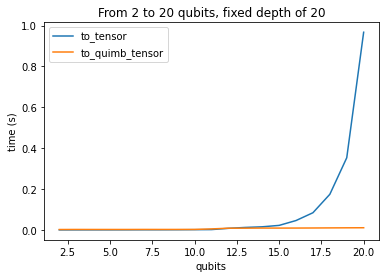

In [2]:
depth = 20
qubits_range = range(2, 21)
cb = CircuitBenchmark(15)
tensor_times, quimb_times = cb.run_with_qubits(depth, qubits_range)
cb.display_plot(tensor_times, quimb_times, qubits_range, has_qubits = True)

The time for transforming the circuit into a normal tensor network and contracting it takes time that increases exponentially with the number of qubits when the depth is fixed, whereas the time for building and contracting the corresponding Quimb tensor network remains (roughly) constant.

Now we fix the number of qubits and change the depth:

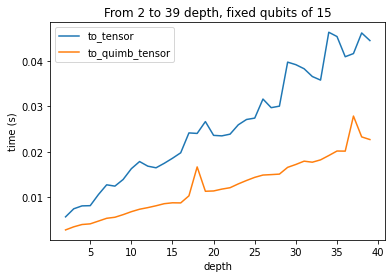

In [3]:
qubits = 15
depth_range = range(2, 40)
tensor_times, quimb_times = cb.run_with_depths(qubits, depth_range)
cb.display_plot(tensor_times, quimb_times, depth_range, has_qubits = False)

Interestingly, as the depth increases and the number of qubits is fixed, both tasks seem to perform the same up to a constant factor; the curves are roughly linear. Quimb definitely has the better constant.

Now we repeat the same experiments but with `full_reduce = True`:

For 20 depth (with full_reduce = True):

Qubits:              2 |       3 |       4 |       5 |       6 |       7 |       8 |       9 |      10
Tensor times:    0.001 |   0.001 |   0.002 |   0.003 |   0.007 |   0.005 |   0.327 |   0.058 |   0.068
Quimb times:     0.001 |   0.002 |   0.003 |   0.005 |   0.007 |   0.007 |   0.009 |   0.008 |   0.009



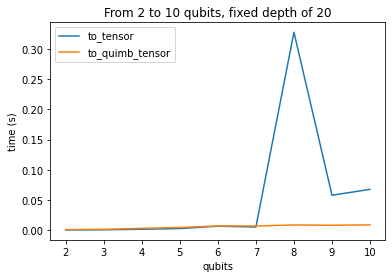

In [4]:
cb = CircuitBenchmark(n = 25, full_reduce = True)
qubits_range = range(2, 11)
tensor_times, quimb_times = cb.run_with_qubits(depth, qubits_range)
cb.display_tabel_and_plot(tensor_times, quimb_times, qubits_range, has_qubits = True)

When the depth is fixed, there are certain situations when the normal method is better, but overall Quimb is better because, as the the number of qubits gets higher, not only it firmly outperforms, but some circuits take exponentially more time to be contracted with `to_tensor`.

For 15 qubits (with full_reduce = True):

Depth:               2 |       3 |       4 |       5 |       6 |       7 |       8 |       9 |      10
Tensor times:    0.007 |   0.008 |   0.009 |   0.009 |   0.011 |   0.014 |   0.020 |   0.020 |   0.025
Quimb times:     0.003 |   0.004 |   0.004 |   0.004 |   0.005 |   0.005 |   0.006 |   0.006 |   0.006



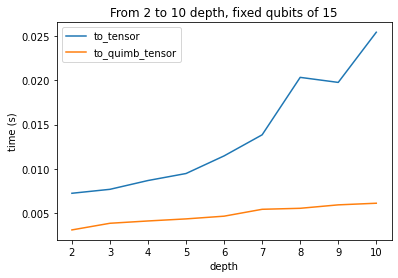

In [5]:
depth_range = range(2, 11)
tensor_times, quimb_times = cb.run_with_depths(qubits, depth_range)
cb.display_tabel_and_plot(tensor_times, quimb_times, depth_range, has_qubits = False)

As with `full_reduce = False`, we got two functions that grow almost the same at the beginning, up to a constant factor, with Quimb having the (much) better constant; then `to_tensor` time increases exponentially.

### Comparing different contraction path finder strategies
Now we will look at different contraction strategies that Quimb can use when performing the contraction. It is very important to note that finding the contraction path and actually performing the contraction are done separately and there is a performance trade off between them.

We employ some Hyper optimizers, namely **Greedy** (an agglomerative approach), **Betweenness** (community detection) and **KaHyPar** (a divisive approach, i.e. building the contraction tree from the top down), as per [this](https://quantum-journal.org/papers/q-2021-03-15-410/) paper.

The class `QuimbStrategies` that we use for this benchmark is very similar to the one above, having methods with the same labels.

In [6]:
class QuimbStrategies:
    def __init__(self, n: int, strategies):
        self.__n = n
        self.__strategies = strategies
    
    def run_with_qubits(self, depth, qubits_range):
        self.__depth = depth
        times = [[] for _ in range(1 + len(self.__strategies))]
        
        for qubits in qubits_range:
            self.__qubits = qubits
            methods_times = self.__run_tensors()
            for i, time in enumerate(methods_times):
                times[i].append(time)
        return times
    
    def __run_tensor(self):
        circuit = zx.generate.CNOT_HAD_PHASE_circuit(qubits = self.__qubits, depth = self.__depth, clifford = False)
        g = circuit.to_graph()
        g.apply_state("0" * self.__qubits)
        g.apply_effect("0" * self.__qubits)
        zx.to_gh(g)
        
        t = time.time()
        tensor = zx.to_quimb_tensor(g).contract(output_inds = ())
        self.__times[0].append(time.time() - t)
        
        for i, method in enumerate(self.__strategies):
            t = time.time()
            tn = zx.to_quimb_tensor(g)
            tn.full_simplify_('ADCRS', output_inds = (), equalize_norms = True)
            tn.contract(optimize = method, output_inds = ())
            self.__times[i + 1].append(time.time() - t)
    
    def __run_tensors(self):
        self.__times = [[] for _ in range(1 + len(self.__strategies))]
        for _ in range(self.__n):
            self.__run_tensor()
        return [np.mean(collection_of_times) for collection_of_times in self.__times]
    
    def display_plot(self, times, range, has_qubits: bool):
        this_type, other_type, quantity = ("qubits", "depth", self.__depth) if has_qubits else \
                                          ("depth", "qubits", self.__qubits)
        fig, ax = plt.subplots()
        for i, method_times in enumerate(times):
            ax.plot(range, method_times, '--', label = "basic" if i == 0 else self.__strategies[i - 1])
        ax.set_xlabel(this_type)
        ax.set_ylabel("time (s)")
        ax.set_title("From {} to {} {}, fixed {} of {}".format(range[0], range[-1], this_type, other_type, quantity))
        ax.legend()

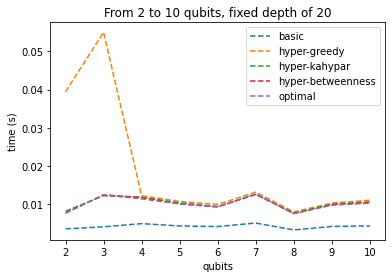

In [7]:
qs = QuimbStrategies(1, ["hyper-greedy", "hyper-kahypar", "hyper-betweenness", "optimal"])
qs.display_plot(qs.run_with_qubits(depth, qubits_range), qubits_range, has_qubits = True)

We conclude that the hyper optimizers perform well and almost the same, but are worse than the basic greedy path optimizer that Quimb employs because of the time needed to find the paths.